In [1]:
import arviz as az
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Dict

from tensorflow_probability.python.internal import dtype_util

tfd = tfp.distributions
tfb = tfp.bijectors

plt.style.use('arviz-darkgrid')

In [2]:
data = np.random.normal(12, 2.2, 200)

@pm.model
def model():
    mu = yield pm.Normal('mu', 0, 10)
    sigma = yield pm.Exponential('sigma', 1)
    ll = yield pm.Normal('ll', mu, sigma, observed=data)

In [3]:
model = model()
state, deterministics_names = pm.inference.utils.initialize_sampling_state(model)
unobserved_keys = state.all_unobserved_values.keys()
print(list(unobserved_keys))

['model/mu', 'model/__log_sigma']


In [4]:
VarMap = collections.namedtuple('VarMap', 'var, slc, shp, dtyp')


class ArrayOrdering:
    """
    An ordering for an array space
    """

    def __init__(self, free_rvs: Dict[str, tf.Tensor]):
        self.free_rvs = free_rvs
        self.by_name = {}
        self.size = 0

        for name, tensor in free_rvs.items():
            flat_shape = int(np.prod(tensor.shape.as_list()))
            slc = slice(self.size, self.size + flat_shape)
            self.by_name[name] = VarMap(name, slc, tensor.shape, tensor.dtype)
            self.size += flat_shape

    def flatten(self):
        flattened_tensor = [tf.reshape(var, shape=[-1]) for var in self.free_rvs.values()]
        return tf.concat(flattened_tensor, axis=0)
    
    def split(self, flatten_tensor):
        flat_state = dict()
        for param in self.free_rvs:
            _, slc, shape, dtype = self.by_name[param]
            flat_state[param] = tf.cast(tf.reshape(flatten_tensor[slc], shape), dtype)
        return flat_state

In [5]:
@tf.function(autograph=False)
def logpfn(*values, **kwargs):
    if kwargs and values:
        raise TypeError("Either list state should be passed or a dict one")
        
    val = ArrayOrdering(state.all_unobserved_values).split(values[0])
    _, st = pm.flow.evaluate_meta_model(model, values=val)
    return st.collect_log_prob()

def vectorize_logp_function(logpfn):
    def vectorized_logpfn(*q_samples):
        return tf.vectorized_map(lambda samples: logpfn(*samples), q_samples)

    return vectorized_logpfn

target_log_prob = vectorize_logp_function(logpfn)

In [6]:
def _build_posterior():
    order = ArrayOrdering(state.all_unobserved_values)
    flattened_shape = order.size
    dtype = dtype_util.common_dtype(state.all_unobserved_values.values(), dtype_hint=tf.float32)
    loc = tf.Variable(tf.random.normal([flattened_shape]), name="mu")
    scale_tril = tfb.FillScaleTriL(
        diag_bijector=tfb.Chain(
            [
                tfb.Shift(tf.cast(1e-3, dtype)),  # diagonal offset
                tfb.Softplus(),
                tfb.Shift(tf.cast(np.log(np.expm1(1.0)), dtype)),  # initial scale
            ]
        ),
        diag_shift=None,
    )

    cov_matrix = tfp.util.TransformedVariable(
        tf.eye(flattened_shape), scale_tril, name="sigma"
    )
    return tfd.MultivariateNormalTriL(loc=loc, scale_tril=cov_matrix)

    
approx = _build_posterior()

In [7]:
opt = pm.adam()

@tf.function(autograph=False)
def run_approximation():
    losses = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob,
        surrogate_posterior=approx,
        num_steps=40000,
        optimizer=opt
    )
    return losses

In [8]:
mean_field = run_approximation()

Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


In [9]:
approx.mean()

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([12.167437 ,  0.7683811], dtype=float32)>

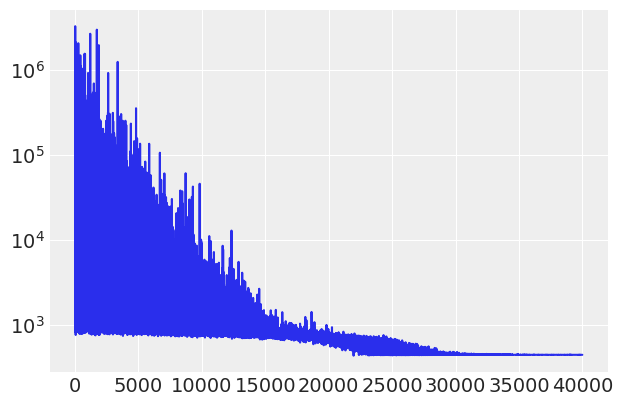

In [10]:
plt.plot(mean_field)
plt.yscale('log')